In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [4]:
def factor(df):
    """
    ËÆ°ÁÆóÂ∞æÁõòËøΩÊ∂®Âõ†Â≠êÔºàÂü∫‰∫éÂ∞æÁõòÊó∂ÊÆµÊ≠£Ë∂ÖÈ¢ùÊî∂ÁõäÂ∫èÂàóÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶Ôºâ
    Ê≠•È™§Ôºö
    1. Á≠õÈÄâÊØèÂ§©Â∞æÁõòÊó∂ÊÆµÊï∞ÊçÆÔºà22:30-23:45 UTCÔºâ
    2. ËÆ°ÁÆó15ÂàÜÈíüÊî∂ÁõäÁéáÂíåË∂ÖÈ¢ùÊî∂ÁõäÁéá
    3. Á≠õÈÄâÊ≠£Ë∂ÖÈ¢ùÊî∂ÁõäÂë®Êúü
    4. ËÆ°ÁÆóÂΩìÂâçÂë®ÊúüÂíå‰∏ã‰∏ÄÂë®ÊúüË∂ÖÈ¢ùÊî∂ÁõäÂ∫èÂàóÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶
    """
    # Â§çÂà∂Êï∞ÊçÆÈÅøÂÖç‰øÆÊîπÂéüÂßãÊï∞ÊçÆ
    df = df.copy()
    
    # Ê∑ªÂä†Êó∂Èó¥ÁâπÂæÅ
    df['time'] = df.index.time
    df['date'] = df.index.date
    
    # ÂÆö‰πâÂ∞æÁõòÊó∂ÊÆµÔºà22:30-23:45 UTCÔºâ
    tail_start = pd.to_datetime('22:30:00').time()
    tail_end = pd.to_datetime('23:45:00').time()
    tail_mask = (df['time'] >= tail_start) & (df['time'] <= tail_end)
    tail_df = df[tail_mask]
    
    # ËÆ°ÁÆóÊî∂ÁõäÁéá
    ret = tail_df['close'].pct_change()
    
    # ËÆ°ÁÆóÊªöÂä®ÂùáÂÄº‰Ωú‰∏∫Âü∫ÂáÜÊî∂ÁõäÁéáÔºà‰ΩøÁî®ÂÖ®Êó∂ÊÆµÊï∞ÊçÆÔºâ
    full_ret = df['close'].pct_change()
    window_size = 1920  # 20Â§© * 96‰∏™15ÂàÜÈíüÂë®Êúü/Â§©
    benchmark_ret = full_ret.rolling(window=window_size, min_periods=1).mean()
    
    # Âè™ÂèñÂ∞æÁõòÊó∂ÊÆµÁöÑÂü∫ÂáÜÊî∂ÁõäÁéá
    tail_benchmark = benchmark_ret[tail_mask]
    
    # ËÆ°ÁÆóË∂ÖÈ¢ùÊî∂ÁõäÁéá
    excess_ret = ret - tail_benchmark
    
    # Âè™‰øùÁïôÊ≠£Ë∂ÖÈ¢ùÊî∂ÁõäÂë®Êúü
    positive_mask = (excess_ret > 0)
    current_er = excess_ret[positive_mask].shift(1)  # ÂΩìÂâçÂë®ÊúüË∂ÖÈ¢ùÊî∂Áõä
    next_er = excess_ret[positive_mask]             # ‰∏ã‰∏ÄÂë®ÊúüË∂ÖÈ¢ùÊî∂Áõä
    
    # ÂàõÂª∫ÁªìÊûúÂ∫èÂàóÔºàÂàùÂßãÂåñ‰∏∫NaNÔºâ
    factor_series = pd.Series(index=df.index, dtype=float)
    
    # ËÆ°ÁÆóÊØèÊó•Â∞æÁõòÊó∂ÊÆµÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶
    for date, group in tail_df.groupby('date'):
        # Ëé∑ÂèñÂΩìÂâçÊó•ÊúüÁöÑÊ≠£Ë∂ÖÈ¢ùÊî∂ÁõäÊï∞ÊçÆ
        date_mask = (current_er.index.date == date)
        current_group = current_er[date_mask]
        next_group = next_er[date_mask]
        
        if len(current_group) < 2:  # ÈúÄË¶ÅËá≥Â∞ë2‰∏™Êï∞ÊçÆÁÇπ
            continue
        
        # ËÆ°ÁÆó‰ΩôÂº¶Áõ∏‰ººÂ∫¶
        numerator = (current_group * next_group).sum()
        denom_current = np.sqrt((current_group ** 2).sum())
        denom_next = np.sqrt((next_group ** 2).sum())
        
        if denom_current * denom_next == 0:
            continue
        
        cosine_sim = numerator / (denom_current * denom_next)
        
        # Â∞ÜÂõ†Â≠êÂÄºËµãÁªôÂΩìÊó•ÊúÄÂêé‰∏Ä‰∏™Â∞æÁõòÂë®Êúü
        last_tail_time = group.index.max()
        factor_series[last_tail_time] = cosine_sim
    
    # ÂêëÂâçÂ°´ÂÖÖÂõ†Â≠êÂÄºÔºà‰ΩøÊØè‰∏™15ÂàÜÈíüÂë®ÊúüÈÉΩÊúâÂÄºÔºâ
    factor_series = factor_series.ffill()
    return factor_series

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üìà Âπ≥Á®≥ÊÄßÊ£ÄÈ™å (ADF):
   p_value: 0.000000
   ÊòØÂê¶Âπ≥Á®≥: ÊòØ
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.012803
   Rank_IC (Spearman): 0.022456
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: -0.414795
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 132111
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------


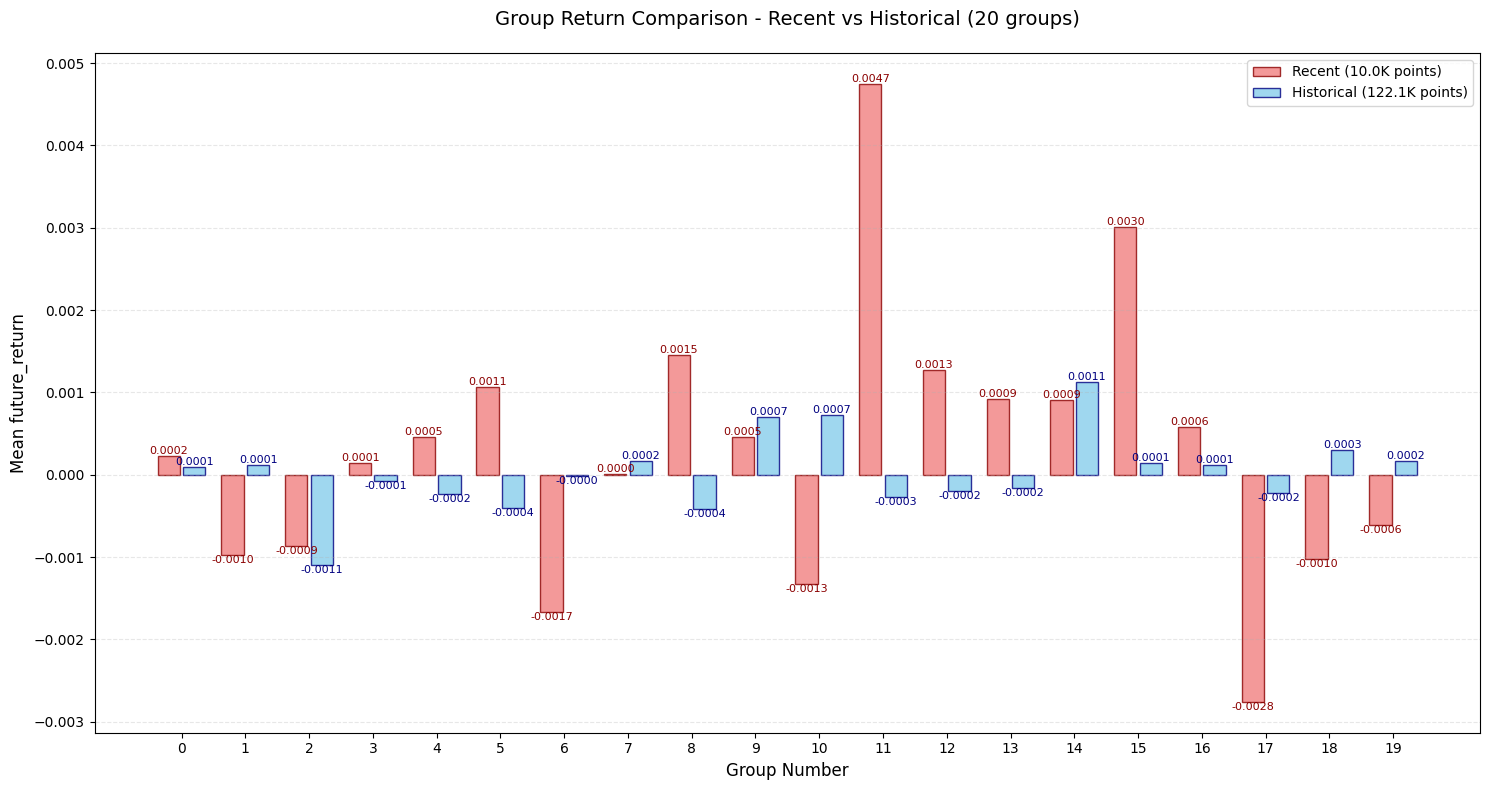

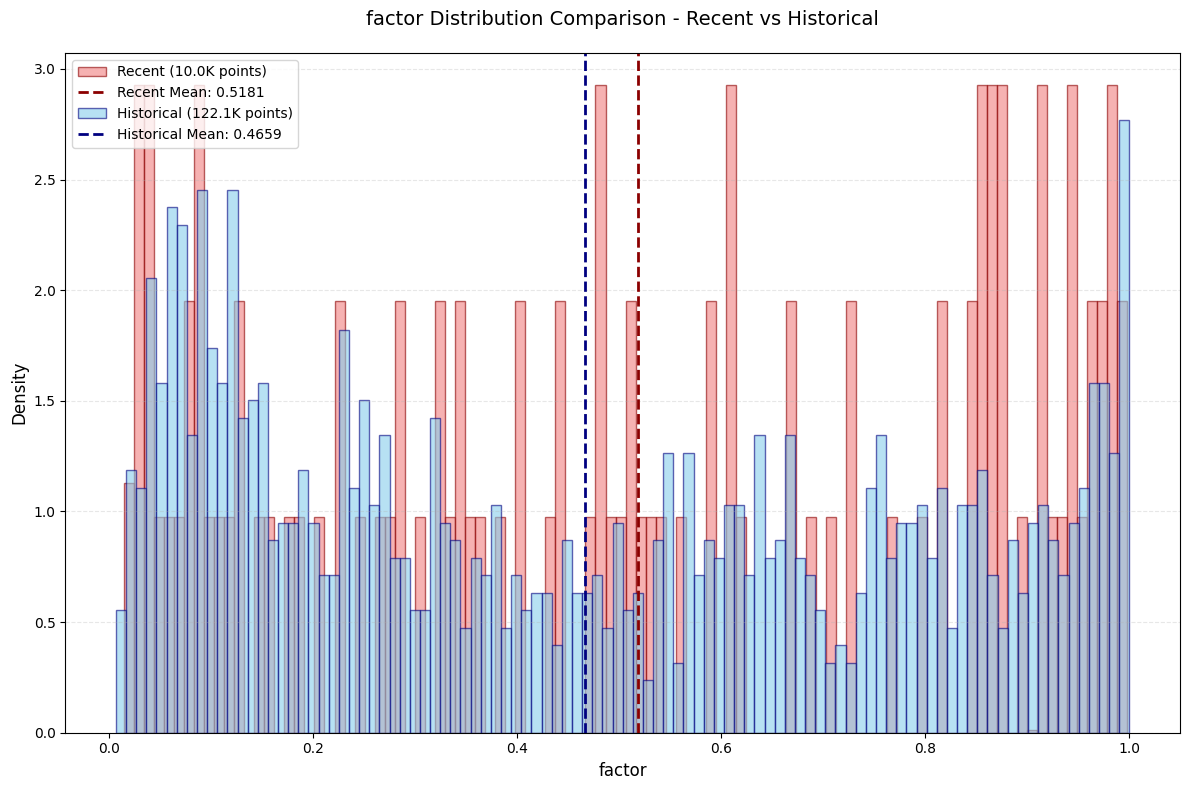

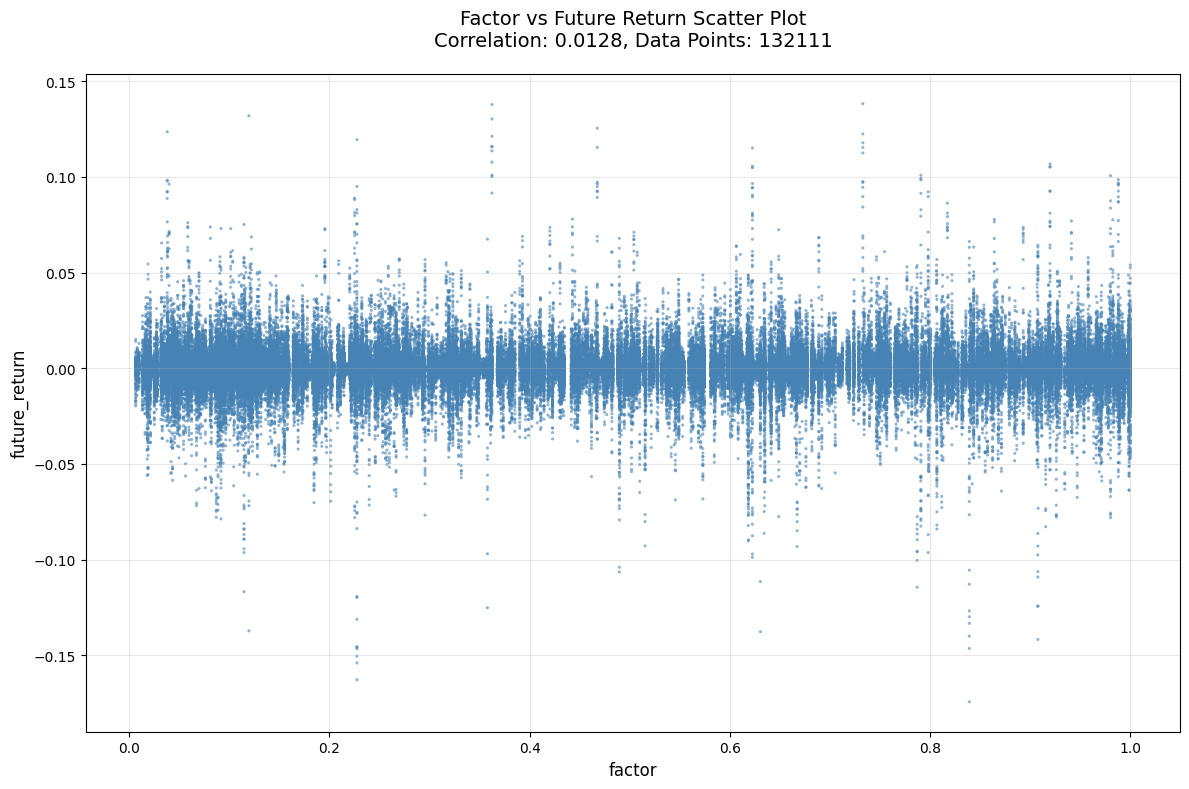

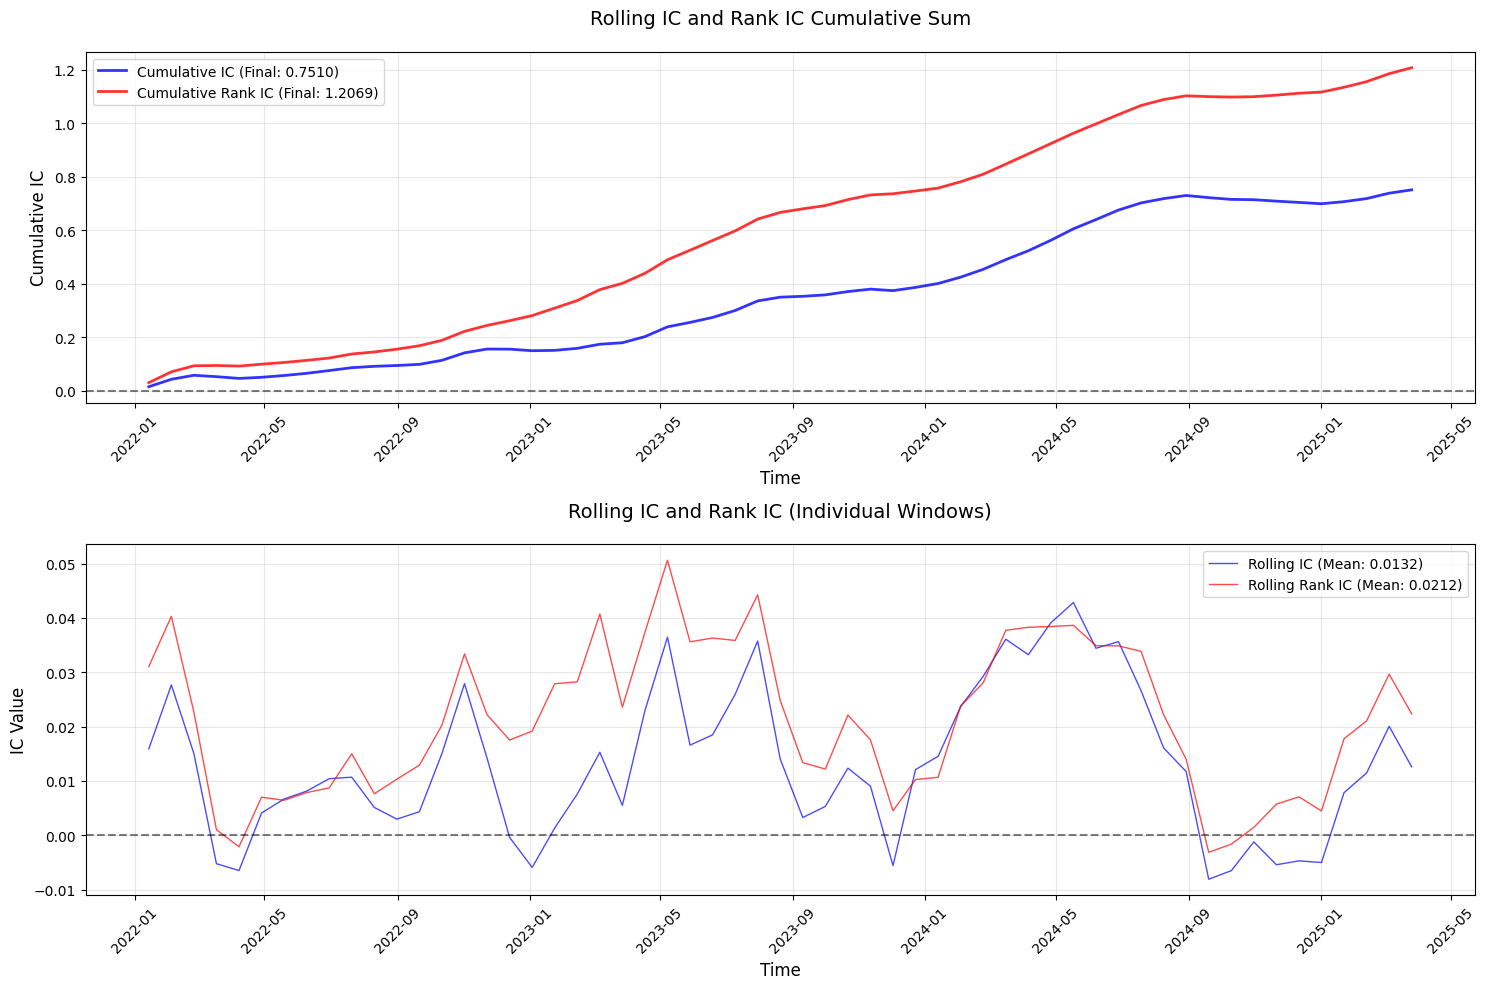

‚úÖ Â∑≤ÊòæÁ§∫ 4 ‰∏™ÂõæÁâá
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [6]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. Âü∫Á°ÄÁªüËÆ°ÊåáÊ†á
    basic_metrics = [
        ["‰ø°ÊÅØÁ≥ªÊï∞(IC)", result['correlation_analysis']['IC']],
        ["Áß©Áõ∏ÂÖ≥Á≥ªÊï∞(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["‰ø°ÊÅØÊØîÁéá(IR)", result['information_ratio']['IR']],
        ["ÂàÜÁªÑÊï∞Èáè", result['information_ratio']['n_groups']],
        ["Êï∞ÊçÆÁÇπÊï∞", f"{result['factor_return_scatter']['data_points']:,}"],
        ["ÂºÇÂ∏∏ÂÄº(>3œÉ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["ÂºÇÂ∏∏ÂÄº(>5œÉ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. ÂàÜÁªÑÂàÜÊûê
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. Âõ†Â≠êÂàÜÂ∏ÉÊèèËø∞
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["ÂùáÂÄº", f"{dist_stats['mean']:.4f}"],
        ["Ê†áÂáÜÂ∑Æ", f"{dist_stats['std']:.4f}"],
        ["ÊúÄÂ∞èÂÄº", f"{dist_stats['min']:.4f}"],
        ["1%ÂàÜ‰ΩçÊï∞", f"{dist_stats['1%']:.4f}"],
        ["5%ÂàÜ‰ΩçÊï∞", f"{dist_stats['5%']:.4f}"],
        ["25%ÂàÜ‰ΩçÊï∞", f"{dist_stats['25%']:.4f}"],
        ["‰∏≠‰ΩçÊï∞", f"{dist_stats['50%']:.4f}"],
        ["75%ÂàÜ‰ΩçÊï∞", f"{dist_stats['75%']:.4f}"],
        ["95%ÂàÜ‰ΩçÊï∞", f"{dist_stats['95%']:.4f}"],
        ["99%ÂàÜ‰ΩçÊï∞", f"{dist_stats['99%']:.4f}"],
        ["ÊúÄÂ§ßÂÄº", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. ÂàÜÁªÑÁõ∏ÂÖ≥ÊÄß
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"ÁªÑ {i+1}", f"{corr:.6f}"])
    
    # 5. ÊªöÂä®ICÂàÜÊûê - ÂÆåÊï¥Â±ïÁ§∫
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # ÂàõÂª∫ÊªöÂä®ICÊï∞ÊçÆË°®Ê†º
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # ÊªöÂä®ICÊ±áÊÄªÁªüËÆ°
    rolling_metrics = [
        ["ÊªöÂä®ICÂùáÂÄº", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["ÊªöÂä®ICÊ†áÂáÜÂ∑Æ", f"{pd.Series(rolling_ic).std():.6f}"],
        ["ÊªöÂä®Rank ICÂùáÂÄº", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["ÊªöÂä®Rank ICÊ†áÂáÜÂ∑Æ", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["Á¥ØÁßØICÁªàÂÄº", f"{cumsum_ic[-1]:.6f}"],
        ["Á¥ØÁßØRank ICÁªàÂÄº", f"{cumsum_rank_ic[-1]:.6f}"],
        ["ÂàùÂßãÁ™óÂè£Â§ßÂ∞è", result['rolling_ic_analysis']['initial_window']],
        ["ÊªöÂä®Ê≠•Èïø", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. Êó∂Èó¥Á™óÂè£ÁªüËÆ°
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # Ê≠£Á°ÆÂ§ÑÁêÜÊó∂Èó¥Á™óÂè£ÁªüËÆ°Êï∞ÊçÆ
    if isinstance(window_data['stats'], pd.DataFrame):
        # Â¶ÇÊûúÊòØDataFrameÁªìÊûÑ
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # Â¶ÇÊûúÊòØÂ≠óÂÖ∏ÁªìÊûÑ
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. Âπ≥Á®≥ÊÄßÊµãËØïÁªìÊûú
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADFÁªüËÆ°Èáè", stationarity['adf_statistic']],
    #     ["PÂÄº", stationarity['p_value']],
    #     ["1%‰∏¥ÁïåÂÄº", stationarity['critical_values']['1%']],
    #     ["5%‰∏¥ÁïåÂÄº", stationarity['critical_values']['5%']],
    #     ["10%‰∏¥ÁïåÂÄº", stationarity['critical_values']['10%']],
    #     ["ÊòØÂê¶Âπ≥Á®≥", stationarity['is_stationary']],
    #     #["ÊòæËëóÊÄßÊ∞¥Âπ≥", stationarity['alpha']]
    # ]
    
    # ÊâìÂç∞ÊâÄÊúâÁªìÊûú
    print("="*80)
    print("Âõ†Â≠êËØÑ‰º∞Ê†∏ÂøÉÊåáÊ†á".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("Âπ≥Á®≥ÊÄßÊµãËØïÁªìÊûú".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÂàÜÁªÑÂàÜÊûêÁªìÊûú".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["ÂàÜÁªÑ", "ÊúÄÂ∞èÂÄº", "ÊúÄÂ§ßÂÄº", "Âπ≥ÂùáÂÄº", "Êî∂ÁõäÂùáÂÄº", "Êî∂ÁõäÊ†áÂáÜÂ∑Æ", "Ê†∑Êú¨Êï∞"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("Âõ†Â≠êÂàÜÂ∏ÉÁªüËÆ°".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["ÁªüËÆ°Èáè", "ÂÄº"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("ÂàÜÁªÑÁõ∏ÂÖ≥ÊÄß".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["ÂàÜÁªÑ", "Áõ∏ÂÖ≥ÊÄß"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÊªöÂä®ICÂàÜÊûêÊ±áÊÄª".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÊªöÂä®ICËØ¶ÁªÜÊï∞ÊçÆ".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["Á™óÂè£‰∏≠ÂøÉ", "ÊªöÂä®IC", "ÊªöÂä®Rank IC", "Á¥ØÁßØIC", "Á¥ØÁßØRank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("Êó∂Èó¥Á™óÂè£ÁªüËÆ°".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["Êó∂Èó¥Á™óÂè£", "ÂùáÂÄº", "Ê†áÂáÜÂ∑Æ", "ÂÅèÂ∫¶", "Lambda", "Ê†∑Êú¨Êï∞"], tablefmt="grid"))
    print(f"Êó∂Èó¥ËåÉÂõ¥: {window_data['time_ranges']}")

# Ë∞ÉÁî®Â±ïÁ§∫ÂáΩÊï∞
display_factor_evaluation(result)

                                    Âõ†Â≠êËØÑ‰º∞Ê†∏ÂøÉÊåáÊ†á                                    
+---------------------+----------------------+
| ÊåáÊ†á                | ÂÄº                   |
+=====================+======================+
| ‰ø°ÊÅØÁ≥ªÊï∞(IC)        | 0.012803238895082471 |
+---------------------+----------------------+
| Áß©Áõ∏ÂÖ≥Á≥ªÊï∞(Rank IC) | 0.022456114506312706 |
+---------------------+----------------------+
| ‰ø°ÊÅØÊØîÁéá(IR)        | -0.41479484017352103 |
+---------------------+----------------------+
| ÂàÜÁªÑÊï∞Èáè            | 10                   |
+---------------------+----------------------+
| Êï∞ÊçÆÁÇπÊï∞            | 132,111              |
+---------------------+----------------------+
| ÂºÇÂ∏∏ÂÄº(>3œÉ)         | 7.85%                |
+---------------------+----------------------+
| ÂºÇÂ∏∏ÂÄº(>5œÉ)         | 0.00%                |
+---------------------+----------------------+

                                     ÂàÜÁªÑÂàÜÊûêÁªìÊûú                